In [ ]:
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # we use both tensorflow and pytorch (pytorch for main part) , tensorflow for tokenizer
from nlp_models import *

In [5]:
import numpy as np
import torch
from autograd_lib import autograd_lib

class DataIQ_Torch:
    def __init__(self, X, y, sparse_labels: bool = False):
        """
        The function takes in the training data and the labels, and stores them in the class variables X
        and y. It also stores the boolean value of sparse_labels in the class variable _sparse_labels

        Args:
          X: the input data
          y: the true labels
          sparse_labels (bool): boolean to identify if labels are one-hot encoded or not. If not=True.
        Defaults to False
        """
        self.X = X
        self.y = y
        self._sparse_labels = sparse_labels

        # placeholder
        self._gold_labels_probabilities = None
        self._true_probabilities = None
        self._grads = None

    def gradient(self, net, device):
        """
        Used to compute the norm of the gradient through training

        Args:
          net: pytorch neural network
          device: device to run the computation on
        """

        # setup
        data = torch.tensor(self.X, device=device)
        targets = torch.tensor(self.y, device=device).long()
        loss_fn = torch.nn.NLLLoss()

        model = net

        # register the model for autograd
        autograd_lib.register(model)

        activations = {}

        def save_activations(layer, A, _):
            activations[layer] = A

        with autograd_lib.module_hook(save_activations):
            output = model(data)
            loss = loss_fn(output, targets)

        norms = [torch.zeros(data.shape[0], device=device)]

        def per_example_norms(layer, _, B):
            A = activations[layer]
            norms[0] += (A * A).sum(dim=1) * (B * B).sum(dim=1)

        with autograd_lib.module_hook(per_example_norms):
            loss.backward()

        grads_train = norms[0].cpu().numpy()

        if self._grads is None:  # Happens only on first iteration
            self._grads = np.expand_dims(grads_train, axis=-1)
        else:
            stack = [self._grads, np.expand_dims(grads_train, axis=-1)]
            self._grads = np.hstack(stack)

    def on_epoch_end(self, net, device="cpu", gradient=True, **kwargs):
        """
        The function computes the gold label and true label probabilities over all samples in the
        dataset

        We iterate through the dataset, and for each sample, we compute the gold label probability (i.e.
        the actual ground truth label) and the true label probability (i.e. the predicted label).

        We then append these probabilities to the `_gold_labels_probabilities` and `_true_probabilities`
        lists.

        We do this for every sample in the dataset, and for every epoch.

        Args:
          net: the neural network
          device: the device to use for the computation. Defaults to cpu
        """

        # in case GPU memory is an issue
        if gradient == True:
          # compute the gradient norm
          self.gradient(net, device) 

        # Compute both the gold label and true label probabilities over all samples in the dataset
        gold_label_probabilities = (
            list()
        )  # gold label probabilities, i.e. actual ground truth label
        true_probabilities = list()  # true label probabilities, i.e. predicted label

        net.eval()
        with torch.no_grad():
            # iterate through the dataset
            for i in range(len(self.X)):

                # set as torch tensors
                x = torch.tensor(self.X[i, :], device=device)
                y = torch.tensor(self.y[i], device=device)

                # forward pass
                probabilities = net(x.reshape(1,-1))
                probabilities = nn.Softmax()(probabilities) # tiny edit due to change of model definition


                # one hot encode the labels
                y = torch.nn.functional.one_hot(
                    y.to(torch.int64), num_classes=probabilities.shape[-1]
                )


                # Now we extract the gold label and predicted true label probas

                # If the labels are binary [0,1]
                if len(torch.squeeze(y)) == 1:
                    # get true labels
                    true_probabilities = torch.tensor(probabilities)

                    # get gold labels
                    probabilities, y = torch.squeeze(
                        torch.tensor(probabilities)
                    ), torch.squeeze(y)

                    batch_gold_label_probabilities = torch.where(
                        y == 0, 1 - probabilities, probabilities
                    )

                # if labels are one hot encoded, e.g. [[1,0,0], [0,1,0]]
                elif len(torch.squeeze(y)) == 2:
                    # get true labels
                    batch_true_probabilities = torch.max(probabilities)

                    # get gold labels
                    batch_gold_label_probabilities = torch.masked_select(
                        probabilities, y.bool()
                    )
                else:

                    # get true labels
                    batch_true_probabilities = torch.max(probabilities)

                    # get gold labels
                    batch_gold_label_probabilities = torch.masked_select(
                        probabilities, y.bool()
                    )

                # move torch tensors to cpu as np.arrays()
                batch_gold_label_probabilities = (
                    batch_gold_label_probabilities.cpu().numpy()
                )
                batch_true_probabilities = batch_true_probabilities.cpu().numpy()

                # Append the new probabilities for the new batch
                gold_label_probabilities = np.append(
                    gold_label_probabilities, [batch_gold_label_probabilities]
                )
                true_probabilities = np.append(
                    true_probabilities, [batch_true_probabilities]
                )

        # Append the new gold label probabilities
        if self._gold_labels_probabilities is None:  # On first epoch of training
            self._gold_labels_probabilities = np.expand_dims(
                gold_label_probabilities, axis=-1
            )
        else:
            stack = [
                self._gold_labels_probabilities,
                np.expand_dims(gold_label_probabilities, axis=-1),
            ]
            self._gold_labels_probabilities = np.hstack(stack)

        # Append the new true label probabilities
        if self._true_probabilities is None:  # On first epoch of training
            self._true_probabilities = np.expand_dims(true_probabilities, axis=-1)
        else:
            stack = [
                self._true_probabilities,
                np.expand_dims(true_probabilities, axis=-1),
            ]
            self._true_probabilities = np.hstack(stack)

    @property
    def get_grads(self):
        """
        Returns:
            Grad norm through training: np.array(n_samples, n_epochs)
        """
        return self._grads

    @property
    def gold_labels_probabilities(self) -> np.ndarray:
        """
        Returns:
            Gold label predicted probabilities of the "correct" label: np.array(n_samples, n_epochs)
        """
        return self._gold_labels_probabilities

    @property
    def true_probabilities(self) -> np.ndarray:
        """
        Returns:
            Actual predicted probabilities of the predicted label: np.array(n_samples, n_epochs)
        """
        return self._true_probabilities

    @property
    def confidence(self) -> np.ndarray:
        """
        Returns:
            Average predictive confidence across epochs: np.array(n_samples)
        """
        return np.mean(self._gold_labels_probabilities, axis=-1)

    @property
    def aleatoric(self):
        """
        Returns:
            Aleatric uncertainty of true label probability across epochs: np.array(n_samples): np.array(n_samples)
        """
        preds = self._gold_labels_probabilities
        return np.mean(preds * (1 - preds), axis=-1)

    @property
    def variability(self) -> np.ndarray:
        """
        Returns:
            Epistemic variability of true label probability across epochs: np.array(n_samples)
        """
        return np.std(self._gold_labels_probabilities, axis=-1)

    @property
    def correctness(self) -> np.ndarray:
        """
        Returns:
            Proportion of times a sample is predicted correctly across epochs: np.array(n_samples)
        """
        return np.mean(self._gold_labels_probabilities > 0.5, axis=-1)

    @property
    def entropy(self):
        """
        Returns:
            Predictive entropy of true label probability across epochs: np.array(n_samples)
        """
        X = self._gold_labels_probabilities
        return -1 * np.sum(X * np.log(X + 1e-12), axis=-1)

    @property
    def mi(self):
        """
        Returns:
            Mutual information of true label probability across epochs: np.array(n_samples)
        """
        X = self._gold_labels_probabilities
        entropy = -1 * np.sum(X * np.log(X + 1e-12), axis=-1)

        X = np.mean(self._gold_labels_probabilities, axis=1)
        entropy_exp = -1 * np.sum(X * np.log(X + 1e-12), axis=-1)
        return entropy - entropy_exp


# Data pre-processing

In [8]:
# Read data of IMDB 50K
# Example from Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

df = pd.read_csv('../data/IMDB-Dataset.csv')
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [9]:
# Convert sentiment columns to numerical values
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

df['kfold'] = -1

# shuffle via random sampling
df = df.sample(frac=1).reset_index(drop=True)

# get label (sentiments)
y = df.sentiment.values


kf = model_selection.StratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(X=df, y=y)):
    df.loc[valid_, 'kfold'] = fold

In [10]:
#load fasttext embeddings - PLACE THE FASTTEXT EMBEDDINGS IN THE DATA FOLDER
print('loading word embeddings...')
fasttext_embedding = {}
f = codecs.open('../data/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fasttext_embedding[word] = coefs
f.close()

loading word embeddings...


111052it [00:09, 11713.20it/s]


In [13]:
def create_embedding_matrix(word_index, embedding_dict=None, d_model=100):
    """
    creates a numpy embedding matrix
    """
    embedding_matrix = np.zeros((len(word_index) + 1, d_model))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

# Helpers

In [15]:
def evaluate(data_loader, model, device):
    # Helper evaluation function
    final_predictions = []
    final_targets = []
    model.eval()

    # since it's test time
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)

            # forward pass
            predictions = model(reviews)

            _, predictions = torch.max(predictions.data, 1)
            predictions = predictions.cpu().numpy().tolist()
            targets = data['target'].cpu().numpy().tolist()
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

In [16]:
def train(data_loader, model, optimizer, device):
    """
    TRAINING LOOP
    """
    model.train()
    # loop through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        targets = data['target']

        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.long)

        optimizer.zero_grad()
        criterion = torch.nn.NLLLoss()
        lsf = nn.LogSoftmax()
        sf = nn.Softmax()

        # forward pass and predict
        predictions = model(reviews)

        loss = criterion(lsf(sf(predictions)), targets)#.view(-1,1))

        # backprop
        loss.backward()
        #single optimization step
        optimizer.step()

# Train LSTM

In [ ]:
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.review.values.tolist())

In [17]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

print('Load fasttext embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=fasttext_embedding, d_model=300)

# we could run this multiple times, but do so once
for fold in range(1):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    # tokenization - we convert the text to sequences to pass to the lstm
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # we need to zero pad to make the length the same
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)

    # Init Data-IQ
    dataiq = DataIQ_Torch(X=xtrain , y=train_df.sentiment.values, sparse_labels=True)
    
    # Data processing
    train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    test_dataset = IMDBDataset(reviews=xtest, targets=valid_df.sentiment.values)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # Model
    device = torch.device('cuda')
    model_fasttext = LSTM(embedding_matrix)
    model_fasttext.to(device)

    optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=1e-3)
    
    print('Training model...')
    EPOCHS=10

    # train for 10 epochs
    for epoch in range(EPOCHS):

        train(train_data_loader, model_fasttext, optimizer, device)

        outputs, targets = evaluate(test_data_loader, model_fasttext, device)

        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'epoch: {epoch}, accuracy: {accuracy}')

        dataiq.on_epoch_end(model_fasttext, device=device, gradient=False)

Load fasttext embedding
Training model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0, accuracy: 0.8381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1, accuracy: 0.8662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 2, accuracy: 0.856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 3, accuracy: 0.8513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 4, accuracy: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 5, accuracy: 0.8809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 6, accuracy: 0.8727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 7, accuracy: 0.8574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 8, accuracy: 0.8555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 9, accuracy: 0.8724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [18]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=cfad1cdd25f28d26e7b283124eb3688722b4647be8963e43e6cde5c0434fc45a
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


# Evaluate Data-IQ

Text(0, 0.5, 'Confidence')

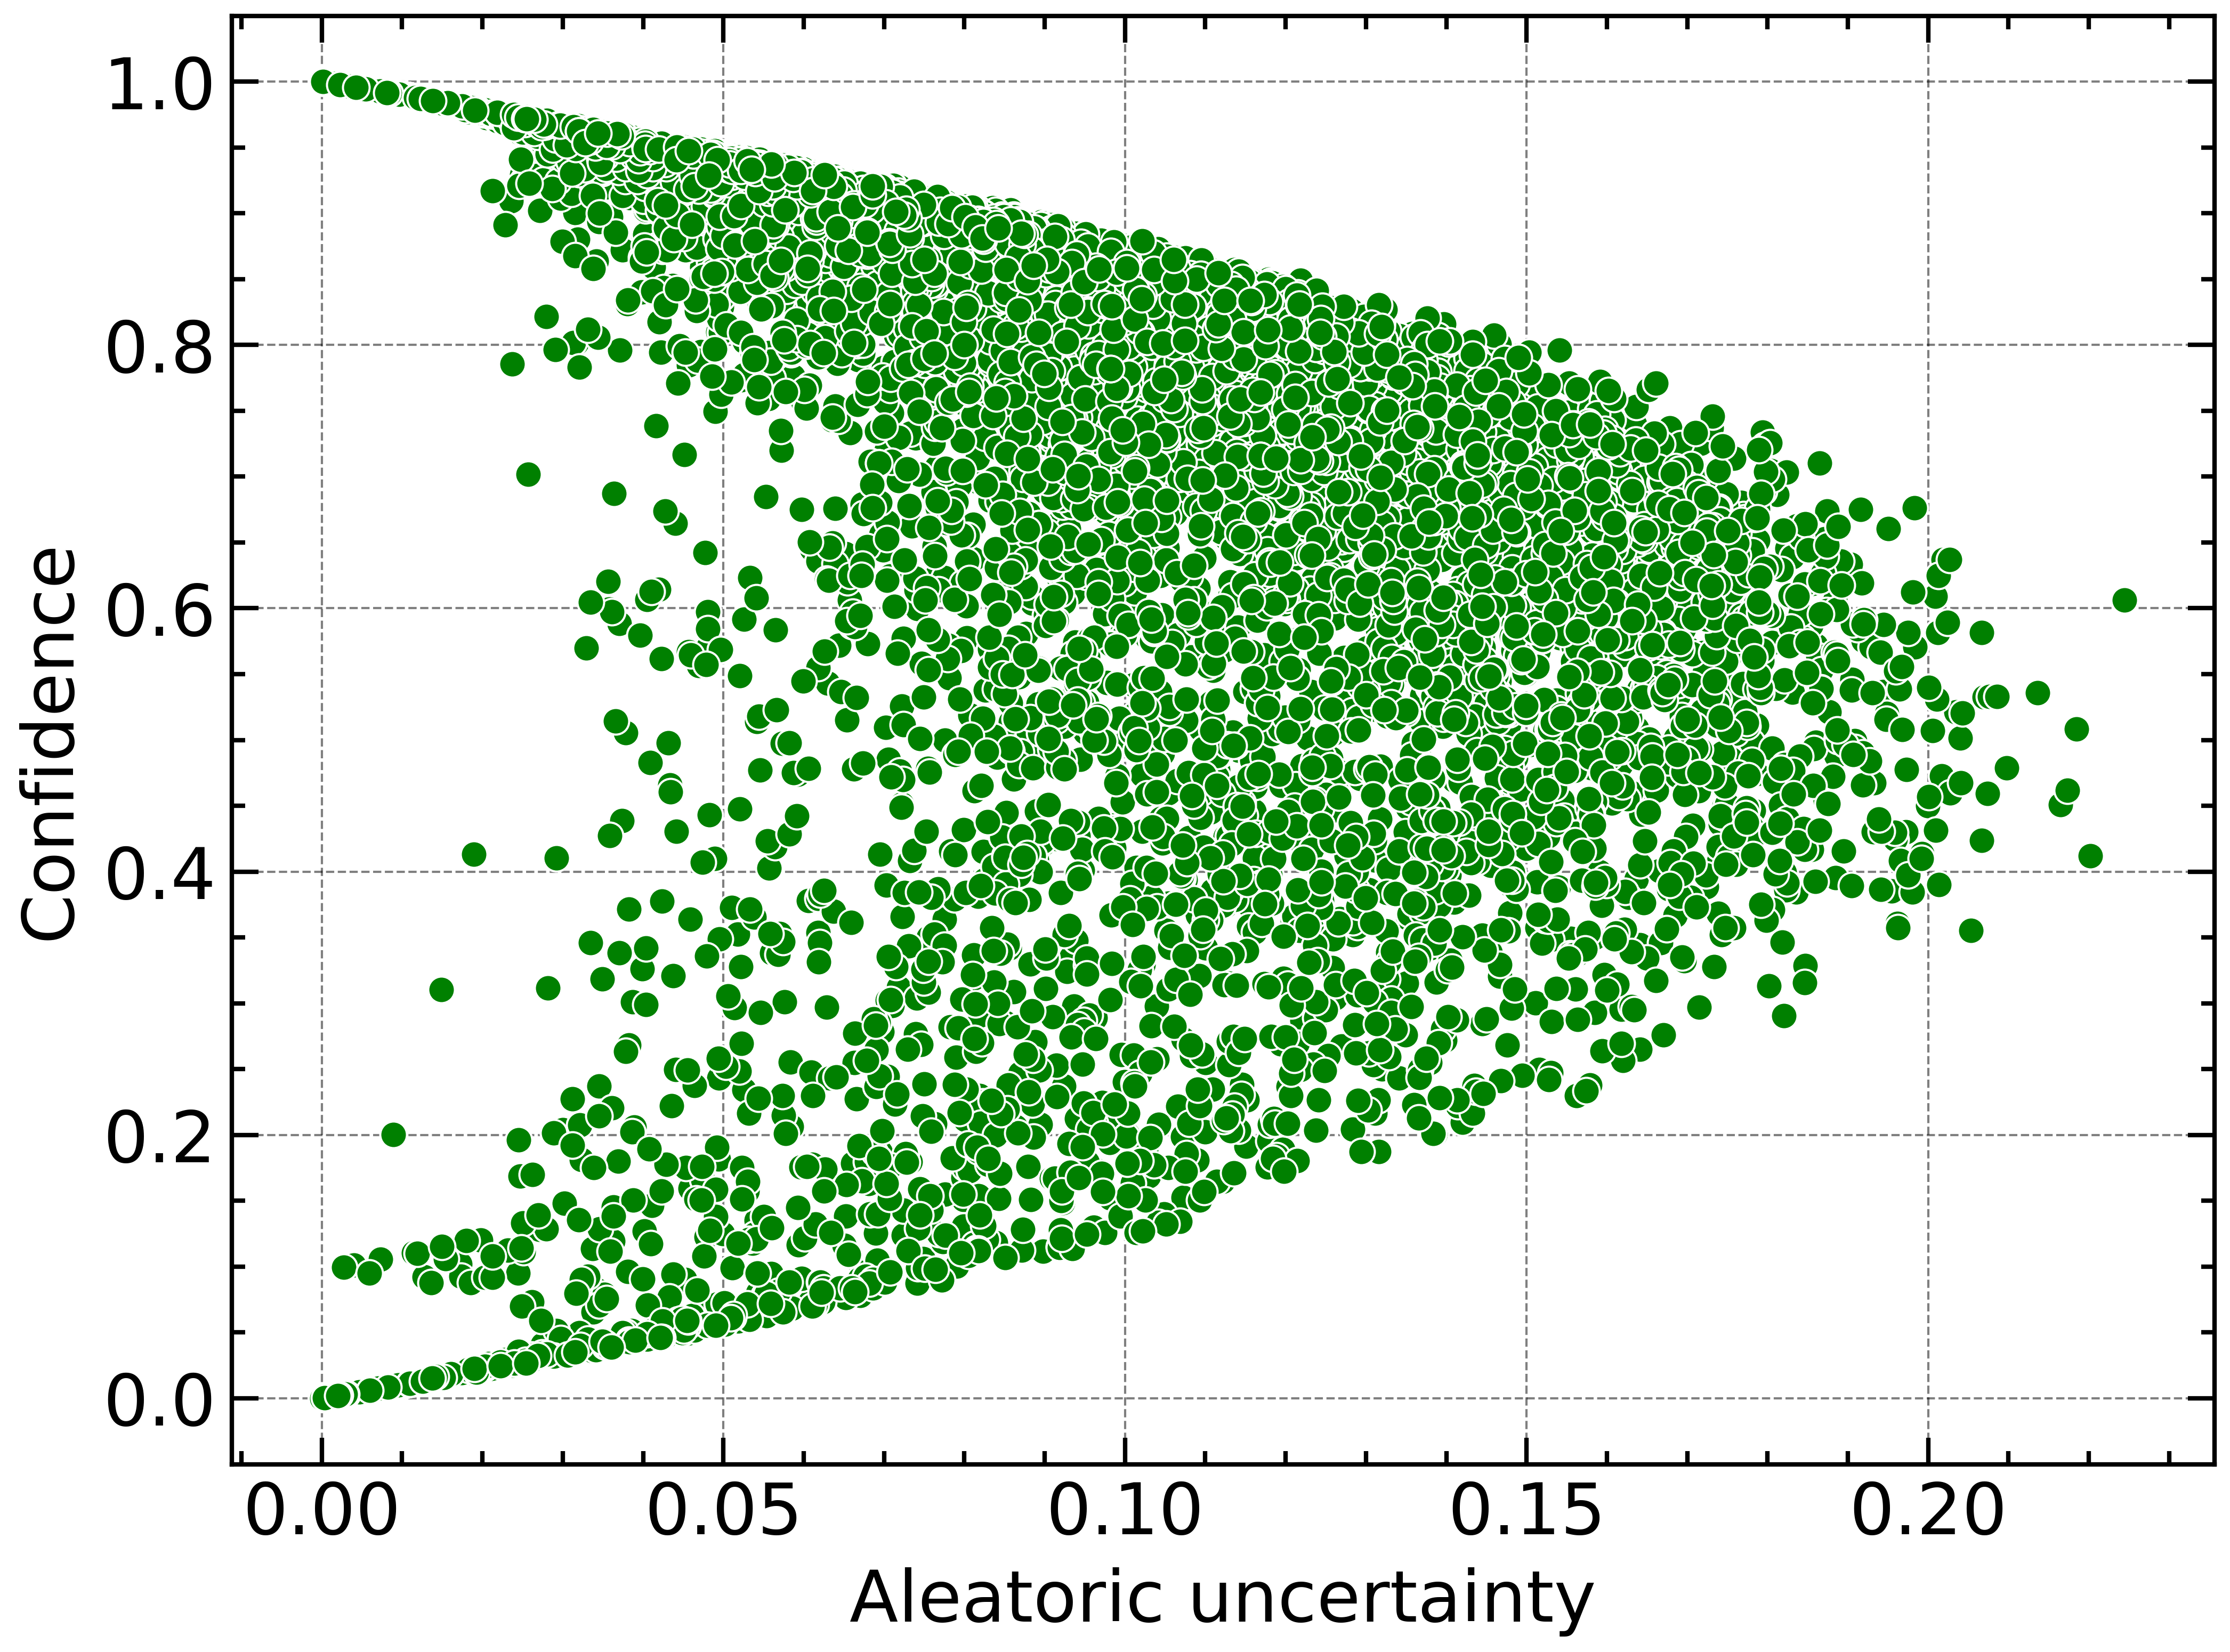

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])

sns.scatterplot(x=dataiq.aleatoric, y=dataiq.confidence, color='g')
plt.xlabel('Aleatoric uncertainty')
plt.ylabel('Confidence')

# Get subgroups

In [20]:
dm = dataiq
aleatoric_train = dataiq.aleatoric
correctness_train = dataiq.correctness
confidence_train = dataiq.confidence
variability_train = dataiq.variability

percentile_thresh = 50
conf_thresh = 0.5
conf_thresh_low = 0.25
conf_thresh_high = 0.75

hard_train = np.where((confidence_train <= conf_thresh_low) & (aleatoric_train <= np.percentile(aleatoric_train,   percentile_thresh)))[0]
easy_train = np.where((confidence_train >= conf_thresh_high) & (aleatoric_train <= np.percentile(aleatoric_train,   percentile_thresh)))[0]

hard_easy = np.concatenate((hard_train,easy_train))
ambig_train = []
for id in range(len(confidence_train)):
  if id not in hard_easy:
    ambig_train.append(id)
ambig_train= np.array(ambig_train)

# Pull out some examples to see what the groups represent

In [53]:
n = 1000

groups = ['Easy', 'Ambig', 'Hard']

group_id = 2

if groups[group_id]=='Easy':
  ids = np.argsort(confidence_train)[-n:]
elif groups[group_id]=='Ambig':
  ids = np.argsort(aleatoric_train)[-n:]
elif groups[group_id]=='Hard':
  ids = np.argsort(confidence_train)[:n]

#### Inspect examples to see what the examples represent

In [54]:
# 1 positive, 0 negative

# Inspect random examples to see what the examples represent
i=1
print(train_df.iloc[ids][['review', 'sentiment']].iloc[i].sentiment)
train_df.iloc[ids][['review', 'sentiment']].iloc[i].review

0


"this one of the best celebrity's reality shows a ever saw. we can see the concerts we can see the life of Britney, i love the five episodes. i was always being surprised by Britney and the subjects of the show i think that some people don't watch the show at all we can how a great person she his. she his really funny really gentle and she loves her fans and we can see how she loves her work. i just don't give a 10 because of k-fed he his a real jerk he doesn't seem to like Britney at all. I they make a second season of this great show because it shows at some people how Britney really is. Go Britney your the best and you will never leave our hearts."